In [52]:
import numpy as np
from numpy.linalg import inv, multi_dot
from numpy import matmul, exp, transpose
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import minimize

In [53]:
# Data: https://www.ecdc.europa.eu/en/publications-data/data-daily-new-cases-covid-19-eueea-country
pd.read_csv("../data/europe_timeseries.csv").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22432 entries, 0 to 22431
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dateRep                  22432 non-null  object 
 1   day                      22432 non-null  int64  
 2   month                    22432 non-null  int64  
 3   year                     22432 non-null  int64  
 4   cases                    22405 non-null  float64
 5   deaths                   22325 non-null  float64
 6   countriesAndTerritories  22432 non-null  object 
 7   geoId                    22432 non-null  object 
 8   countryterritoryCode     22432 non-null  object 
 9   popData2020              22432 non-null  int64  
 10  continentExp             22432 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 1.9+ MB


In [54]:
class timeSeries():
    """
    Beispiel 2.7.
    Hier wird der Datensatz aus dem obigen Link bearbeitet und an unsere 
    Bedürfnisse angepasst. Der Datensatz beinhaltet die Anzahl an Neuinfektionen
    aller europäischen Länder seit Ausbruch der Epidemie. 
    """
    def __init__(self, df: pd.DataFrame, country: str, start: str, end: str):
        """
        Konstruktor
        Args:
            df (obj): gegebener Datensatz
            country (str): Land, dessen Daten extrahiert werden sollen
            start (str): yyyy-mm-dd
            end (str): yyyy-mm-dd 
        """
        self.country = country
        df.loc[:,'dateRep'] = pd.to_datetime(df.dateRep, format='%d/%m/%Y')
        self.start = start
        self.end = end
        self.rawData = df
        self.processedData = self.extract_country_and_time(start, end)

    def extract_country_and_time(self, start_str: str, end_str: str) -> pd.DataFrame:
        """
        Filtert den Datensatz nach dem Land und der Zeitperiode 
        Args:
            start (str): yyyy-mm-dd
            end (str): yyyy-mm-dd
        Gibt zubereitete Daten zurück
        """
        
        df = self.rawData.copy(deep = False)

        # Daten des jeweiligen Landes extrahieren
        df = df[df.countriesAndTerritories == self.country]

        # Überflüssige Spalten entfernen
        df = df[["dateRep", "day", "month", "year", "cases"]]
        df = df.sort_values(["year", "month","day"]) 
    
        # Daten als Index setzen
        df = df.set_index('dateRep')

        # Fehlende Datenpunkte mit nan füllen
        idx = pd.date_range(df.index[0], df.index[-1])
        df = df.reindex(idx, fill_value=np.nan)

        # Lineare Interpolation der nan-Werte
        df.loc[:,"cases"] = df.loc[:,"cases"].interpolate(method="linear")

        # Zwei Spalten hinzufügen:
        # - Kumulative Zahl an Neuinfektionen
        # - Zahl der derzeit infizierten Personen (mit einer mittleren Infektionsdauer von 14 Tagen)
        df.loc[:,"cumCases"] = df.loc[:,"cases"].cumsum(axis=0)
        df.loc[:,"I"] = df.loc[:,"cases"].rolling(window=14).sum()

        # Zeitfenster auswählen

        try:
            start = pd.to_datetime(start_str)
            df = df.loc[start:]
        except:
            if (start_str != "start"):
                print("Wrong input")

        try:
            end = pd.to_datetime(end_str)
            df = df.loc[:end]
        except:
            if (end_str != "end"):
                print("Wrong input")

        # Variable t hinzufügen (Zeit in Tagen)
        df.loc[:,"t"] = list(range(len(df)))
                
        return df

    def linear_regression(self):
        """
        Gibt eine Schätzung von
        - beta (Infektionsrate)
        - I0 (Anfangswert)
        für das ausgewähle Land und die ausgewähle Zeitperiode
        """

        # Formtierung
        df = self.processedData.loc[:,("t","cumCases")].set_index("t").copy(deep=False)
        t = np.array(df.loc[1:].index,dtype=np.float64).reshape(-1, 1)
        I = np.array(df.loc[1:, "cumCases"],dtype=np.float64).reshape(-1, 1)

        # Lin-Log Regression
        X = np.concatenate((t,np.ones((len(t),1))),axis=1)
        XT = X.transpose()
        y = np.log(I)
        beta_hat = np.double(multi_dot([inv(matmul(XT, X)),XT,y])).round(4)
        I_0 = exp(beta_hat[1]).round(2)
        prediction = I_0 * exp(beta_hat[0] * t)
        
        # Visualisierung
        _, ax = plt.subplots(figsize = (8,5))
        ax.margins(0.05)
        ax.set_title(f"{self.start} bis {self.end}", fontsize = 22)
        ax.plot(df.loc[1:].index,prediction, label="LAP", color="red",)
        ax.plot(df.loc[1:].index,df.cumCases[1:], label="Echte Daten", color="blue",marker=".", ls='none')
        ax.text(0.4, 0.85, f"$\hat \\beta = {beta_hat[0][0]}, \hat I_0 = {np.float64(I_0)}$", transform=ax.transAxes, fontsize=20)
        plt.rc('legend',fontsize=16)
        ax.legend()
        plt.show() 

        return beta_hat.reshape(2,)
    
    def nonlinear_regression(self):
        """
        Sollte die Parameter beta und I0 mithilfe der Newton-Methode approximieren.
        Aufgrund zweier Gründe kommt man allerdings zu keinen verwertbaren Ergebnissen:
        - Je nach Datenpunkten ist die Matrix F'(xk)^T*F'(xk) singular 
        - Wegen der Exponentialfunktion sind die Werte der Fehlerfunktion zu groß für den Computer
        """
        df = self.processedData
        t = np.array(df.loc[df["t"] > 0, "t"],dtype=np.float64).reshape(-1, 1)
        I = np.array(df.loc[df["t"] > 0, "cumCases"],dtype=np.float64).reshape(-1, 1)

        # Newton's Method
        def G(b):
            b0 = b[0]
            b1 = b[1]
            return np.log(matmul(transpose(I - b1*exp(b0*t)), I - b1*exp(b0*t)))

        # G'(x)
        def dGdb(b):
            b0 = b[0]
            b1 = b[1]
            Gb = G(b)
            dGdb0 = 1/(Gb) * 2*b1 * np.matmul(transpose(b1 * exp(b0*t)-I),t * exp(b1 * t))
            dGdb1 = 1/(Gb)*2* matmul(transpose(b1 * exp(b0*t)-I),exp(b0*t))
            return np.array([dGdb0, dGdb1]).reshape(2,)

        beta_hat = self.linear_regression()
        #beta_hat = np.array([0.2,1.0])
        beta_star = minimize(G, x0=beta_hat, method="Newton-CG", jac=dGdb).x.round(4)
        prediction = beta_star[1] * exp(beta_star[0] * t)
        

        _, ax = plt.subplots(figsize = (8,5))
        ax.margins(0.05)

        ax.set_title(f"{self.start} bis {self.end}, $I_0 = {beta_star[1]}$", fontsize = 22)
        ax.plot(df.t[1:],prediction, label="Newton-Meth.", color="red",)
        ax.plot(df.t[1:],df.cumCases[1:], label="Fallzahlen", color="blue",marker=".",ls='none')
        ax.text(0.45, 0.8, f"$ \\beta^* = $ {(beta_star[0],beta_star[1])}", transform=ax.transAxes, fontsize=18)
        plt.rc('legend',fontsize=16)

        ax.legend()
        plt.show()
        return beta_star

    def export(self):
        start_str = "".join(self.start.split("-"))
        end_str = "".join(self.end.split("-"))
        filename = f"{self.country}_{start_str}-{end_str}"
        self.processedData[["t","cumCases"]].to_csv(f"../Matlab/data/{filename}.csv")

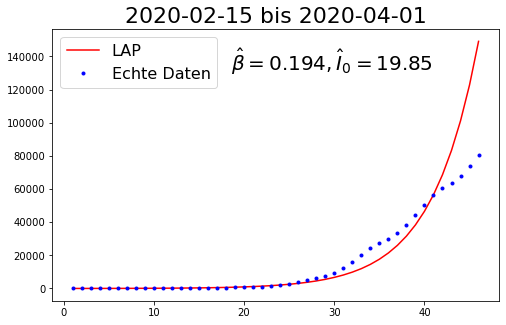

array([0.194 , 2.9883])

In [65]:
df = pd.read_csv("../data/europe_timeseries.csv")
ts1 = timeSeries(df, "Germany", "2020-02-15", "2020-04-01")
ts1.linear_regression()

In [67]:
# Folgendermaßen kann man den Datensatz zu einem bestimmten Land und Zeitraum exportieren

# ts2 = timeSeries(df, "Spain", "2020-02-15", "2020-04-01")
# ts2.export()